In [3]:
# -*-coding:utf-8-*-
%matplotlib inline
import os

import numpy as np
from matplotlib import pyplot as plt
from sklearn.cross_validation import KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

from bald_latin import remove_cyrillic_and_accents as balden

### Load the original and stemmed comments, and their labels.
Remove the cyrillic comments and remove accents from ć,č,ž,š,đ.

In [ ]:
# comments collected by the "Lovac na sendvice" app
def load_comments_and_labels():
    lns_comments = balden(open('dataset/lns/lns_comments.txt', 'r').readlines())
    lns_stemmed = open('dataset/lns/lns_comments_stemmed.txt', 'r').readlines()
    lns_labels = open('dataset/lns/lns_labels.txt', 'r').readlines()
    
    # remove cyrillic and accents on stemmed comments
    lns_stemmed, lns_labels = balden(lns_stemmed, lns_labels)
    
    # labels as a numpy array
    lns_labels = np.array([int(float(x)) for x in lns_labels])
    
    assert len(lns_comments)     == len(lns_stemmed)
    return lns_comments, lns_stemmed, lns_labels
   
def load_scraped():
    # scraped comments from Blic.rs
    scraped_comments = balden(open('dataset/scraped/comments.txt').readlines())
    scraped_stemmed  = balden(open('dataset/scraped/comments_stemmed.txt').readlines())
    
    assert len(scraped_comments) == len(scraped_stemmed)
    return scraped_comments, scraped_stemmed

def load_scraped_not_category():
    scraped_nots_comments = balden(open('dataset/scraped/slobodno_vreme.txt').readlines())
    scraped_nots_stemmed = balden(open('dataset/scraped/slobodno_vreme_stemmed.txt').readlines())
    
    assert len(scraped_nots)     == len(scraped_nots_stemmed)
    return scraped_nots_comments, scraped_nots_stemmed

lns_comments, lns_stemmed, lns_labels = load_comments_and_labels()
scraped_comments, scraped_stemmed = load_scraped()
scraped_nots_comments, scraped_nots_stemmed = load_scraped_not_category()

### Create a vectorizer, add methods for testing predictions

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

croatian_stop_words = set([u"a",u"ako",u"ali",u"bi",u"bih",u"bila",u"bili",u"bilo",u"bio",u"bismo",u"biste",u"biti",u"bumo",u"da",u"do",u"duž",u"ga",u"hoće",u"hoćemo",u"hoćete",u"hoćeš",u"hoću",u"i",u"iako",u"ih",u"ili",u"iz",u"ja",u"je",u"jedna",u"jedne",u"jedno",u"jer",u"jesam",u"jesi",u"jesmo",u"jest",u"jeste",u"jesu",u"jim",u"joj",u"još",u"ju",u"kada",u"kako",u"kao",u"koja",u"koje",u"koji",u"kojima",u"koju",u"kroz",u"li",u"me",u"mene",u"meni",u"mi",u"mimo",u"moj",u"moja",u"moje",u"mu",u"na",u"nad",u"nakon",u"nam",u"nama",u"nas",u"naš",u"naša",u"naše",u"našeg",u"ne",u"nego",u"neka",u"neki",u"nekog",u"neku",u"nema",u"netko",u"neće",u"nećemo",u"nećete",u"nećeš",u"neću",u"nešto",u"ni",u"nije",u"nikoga",u"nikoje",u"nikoju",u"nisam",u"nisi",u"nismo",u"niste",u"nisu",u"njega",u"njegov",u"njegova",u"njegovo",u"njemu",u"njezin",u"njezina",u"njezino",u"njih",u"njihov",u"njihova",u"njihovo",u"njim",u"njima",u"njoj",u"nju",u"no",u"o",u"od",u"odmah",u"on",u"ona",u"oni",u"ono",u"ova",u"pa",u"pak",u"po",u"pod",u"pored",u"prije",u"s",u"sa",u"sam",u"samo",u"se",u"sebe",u"sebi",u"si",u"smo",u"ste",u"su",u"sve",u"svi",u"svog",u"svoj",u"svoja",u"svoje",u"svom",u"ta",u"tada",u"taj",u"tako",u"te",u"tebe",u"tebi",u"ti",u"to",u"toj",u"tome",u"tu",u"tvoj",u"tvoja",u"tvoje",u"u",u"uz",u"vam",u"vama",u"vas",u"vaš",u"vaša",u"vaše",u"već",u"vi",u"vrlo",u"za",u"zar",u"će",u"ćemo",u"ćete",u"ćeš",u"ću",u"što"])

# build tf-idf vectorizer which uses unigrams and bigrams.
# uses words with 2+ occurances as features
vectorizer = TfidfVectorizer(
    strip_accents="unicode",
    lowercase=True,
    ngram_range=(1, 2),
    min_df=10,
    norm='l2',
    smooth_idf=True,
    use_idf=True,
    stop_words=croatian_stop_words)


def round_pred(y_pred):
    return np.round(y_pred).astype(np.int)


def test_prediction(y_true, y_pred):
    y_pred = round_pred(y_pred)
    
    funcs = [accuracy_score, precision_score, recall_score, confusion_matrix]
    vals = [func(y_true, y_pred) for func in funcs]
    
    return vals


def test_prediction_above(y_true, y_pred, threshold):
    indices = list(np.argwhere(np.logical_or(y_pred > threshold, y_pred < 1 - threshold)).flatten())
    if len(indices) == 0:
        return [0, 0, 0, [[0, 0], [0, 0]]]
    
    y_pred = round_pred([y_pred[x] for x in indices])
    y_true = [y_true[x] for x in indices]
    
    return test_prediction(y_true, y_pred)

# Train a Naive Bayes classifier using K-Fold crossvalidation
### Test it on each test set, average the results

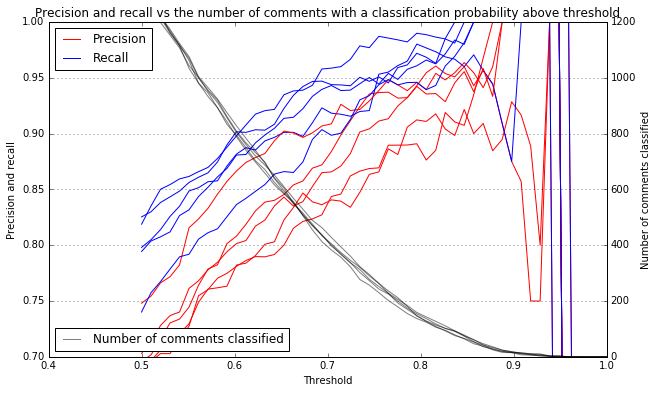

In [41]:
n_folds = 5
num_classified = []

# Split the dataset into k folds, each fold is a test set for one iteration
k_fold = KFold(len(lns_stemmed), n_folds=n_folds, shuffle=False)
for fold_count, (train, test) in enumerate(k_fold):
    text_train = [lns_stemmed[x] for x in train]
    text_test  = [lns_stemmed[x] for x in test]
    y_train = [lns_labels[x] for x in train]
    y_test  = [lns_labels[x] for x in test]
    
    # build the dataset, vectorize it using TF-IDF
    X_train = vectorizer.fit_transform(text_train)
    X_test  = vectorizer.transform(text_test)
        
    # create and fit the classifier
    clf = MultinomialNB().fit(X_train, y_train)
    
    # predict on the test set
    y_pred = clf.predict_proba(X_test)[:,1]
    
    # plot precision/recall for different thresholds
    thresholds = np.linspace(0.5, 1)
    prec, rec, nums = [], [], []
    for threshold in thresholds:
        a, p, r, c = test_prediction_above(y_test, y_pred, threshold) 
        num = np.sum(np.logical_or(y_pred > threshold, y_pred < 1 - threshold))
        prec.append(p); rec.append(r); nums.append(num)
        
    plt.figure(1, figsize=(10,6))
    plt.ylim(0.7, 1)
    plt.plot(thresholds, prec, label='Precision' if not fold_count else None, color='r')
    plt.plot(thresholds, rec,  label='Recall'    if not fold_count else None, color='b')
    plt.ylabel("Precision and recall")
    plt.legend(loc='upper left')
    
    num_classified.append(nums)

plt.xlabel("Threshold")
plt.twinx()
plt.ylim(0, 1200)
for i, num in enumerate(num_classified):
    plt.plot(thresholds, num, label="Number of comments classified" if not i else None, color='k', alpha=0.5)

plt.title("Precision and recall vs the number of comments with a classification probability above threshold")
plt.ylabel("Number of comments classified")
plt.grid()
plt.legend(loc='lower left')
plt.show()

## Once we have picked a threshold for bot classification, lets classify the scraped comments
### With the scraped comments, add the scraped not-bots and train an LSTM

In [44]:
n_folds = 5
threshold = 0.84
unlabeled_len = 10 ** 5
weight = 0.1

# Split the dataset into k folds, each fold is a test set for one iteration
k_fold = KFold(len(lns_stemmed), n_folds=n_folds, shuffle=False)
for fold_count, (train, test) in enumerate(k_fold):
    text_train = [lns_stemmed[x] for x in train]
    text_test  = [lns_stemmed[x] for x in test]
    y_train = [lns_labels[x] for x in train]
    y_test  = [lns_labels[x] for x in test]
    
    unlabeled_stemmed = scraped_stemmed[:unlabeled_len]
    
    # build the dataset, vectorize it using TF-IDF
    X_train = vectorizer.fit_transform(text_train)
    X_test  = vectorizer.transform(text_test)
    print unlabeled_stemmed
    X_unlabeled = vectorizer.transform(unlabeled_stemmed)
        
    # create and fit the classifier
    clf = MultinomialNB().fit(X_train, y_train)
    
    # predict on the unlabeled set
    y_pred = clf.predict_proba(X_unlabeled)[:,1]
    indices = np.logical_or(y_pred > threshold, y_pred < 1 - threshold)
        
    # using the NB predictions, pull the bots from the original comments
    classified_bots = [scraped_comments[x] for x in indices]
    # and take the same number of comments from the not categories
    classified_nots = scraped_nots[:len(classified_bots)]
    
    # build dataset from the original unstemmed lns comments, 
    # newly classified bot comments, and manually tagged not comments
    combined_set = lns_comments + classified_bots + classified_nots
    combined_labels = list(lns_labels) + list(np.ones(len(classified_bots))) + list(np.zeros(len(classified_nots)))
    combined_labels = np.array(combined_labels)
    # the weigths of the new samples are decreased
    combined_weights = np.ones(len(combined_labels))
    combined_weights[len(lns_comments):] = weight
    

MemoryError: 

## Label a dataset from the scraped comments and train the network on it
### For each fold, train a separate network

In [ ]:
n_folds=3
values = np.zeros(3)  # accuracy, precision, recall
probabilities = []

# Split the dataset into k folds, each fold is a test set for one iteration
k_fold = KFold(len(corpus), n_folds=n_folds, shuffle=True)
for fold_count, (train, test) in enumerate(k_fold):
    # training sets, tests set, scraped stemmed comments, and comments from specific categories
    corpus_train = [corpus[x] for x in train]
    corpus_test = [corpus[x] for x in test]
    labels_train = [labels[x] for x in train]
    labels_test = [labels[x] for x in test]
    
    
    
    # build the dataset, vectorize it using TF-IDF
    data = CommentDataset(corpus_train, labels_train, corpus_test, labels_test)
    data.vectorize_fit()
        
    # create and fit the classifier
    clf = MultinomialNB().fit(data.X_train, data.y_train)
    
    proba = clf.predict_proba(data.X_test)[:,1]
    probabilities.append(proba)
    
    values += data.test_prediction(proba, print_options=[])[:3]  # for averaging metrics on k-folds
    
print "Results on {} folds:".format(fold_count + 1)
print ("Accuracy: {},\nPrecision: {},\nRecall: {}".format(values[0]/n_folds, values[1]/n_folds, values[2]/n_folds))


# plots
plt.figure(figsize=(13, 4))
for fold, proba in enumerate(probabilities):
    n, bins, patches = plt.hist(proba, 100, alpha=0.5, label="Fold #{}".format(fold))
plt.legend(loc='upper right')
plt.show()